In [60]:
import warnings
warnings.filterwarnings("ignore", "in-band")

import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
#from sklearn.utils.extmath import randomized_svd
import sklearn
from sklearn.decomposition import IncrementalPCA, randomized_svd, KernelPCA
import sklearn.decomposition 

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
from river.data.dataset import DatasetSVDStrainFDFromSVDWFonGPU, DatasetSVDStrainFDFromSVDWFonGPUBatch#DatasetStrainFD, #DatasetStrainFDFromPreCalSVDWF
#import river.data.utils as datautils
from river.data.utils import *

from river.models import embedding
from river.models.utils import *

import sealgw
import lal

import time

In [2]:
#ifos = sealgw.simulation.sealinterferometers.SealInterferometerList(['H1', 'L1', 'V1', 'ET', 'CE','CEL'])
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])

In [3]:
det = ifos[0]

In [4]:
det.geometry.detector_tensor

array([[-0.3926141 , -0.07761341, -0.24738904],
       [-0.07761341,  0.31952407,  0.22799783],
       [-0.24738904,  0.22799783,  0.07309003]])

In [5]:
det.vertex

array([-2161414.92636   , -3834695.17888835,  4600350.22663899])

In [3]:

class GWAntennaOnCPU():
    def __init__(self, detector_names):
        self.ifos = sealgw.simulation.sealinterferometers.SealInterferometerList(detector_names)

    def getgha(self, gpstime, ra):
        # Greenwich hour angle of source (radians).
        gha = np.zeros_like(gpstime) - ra
        for i,gpst in enumerate(gpstime):
            gha[i] += bilby.gw.utils.greenwich_mean_sidereal_time(gpst)
        return gha
    
    def response(self, ra, dec, psi, gpstime):
        bs = ra.shape[0]
        
        X = np.zeros((bs, 3))
        Y = np.zeros((bs, 3))

        
        gha = self.getgha(gpstime, ra)

        cosgha = np.cos(gha)
        singha = np.sin(gha)
        cosdec = np.cos(dec)
        sindec = np.sin(dec)
        cospsi = np.cos(psi)
        sinpsi = np.sin(psi)
    
        X[:,0] = -cospsi * singha - sinpsi * cosgha * sindec
        X[:,1] = -cospsi * cosgha + sinpsi * singha * sindec
        X[:,2] =  sinpsi * cosdec

        Y[:,0] =  sinpsi * singha - cospsi * cosgha * sindec
        Y[:,1] =  sinpsi * cosgha + cospsi * singha * sindec
        Y[:,2] =  cospsi * cosdec
        
        resp_dict = {}
        for det in self.ifos:
            D = det.detector_tensor
            fp = np.einsum('ij,jk,ik->i', X, D, X) - np.einsum('ij,jk,ik->i', Y, D, Y)
            fc = np.einsum('ij,jk,ik->i', X, D, Y) + np.einsum('ij,jk,ik->i', Y, D, X)
            resp_dict[det.name] = (fp, fc)

        return resp_dict
    
    def time_delay_from_geocenter(self, ra, dec, gpstime):
        bs = ra.shape[0]
        gha = self.getgha(gpstime, ra)
        
        cosgha = np.cos(gha)
        singha = np.sin(gha)
        cosdec = np.cos(dec)
        sindec = np.sin(dec)
        
        wavevector = np.zeros((bs, 3))
        wavevector[:,0],wavevector[:,1],wavevector[:,2]  = \
            -cosgha*cosdec, cosdec*singha, -sindec
        
        dt_dict = {}
        for det in self.ifos:
            loc = det.vertex
            dt = np.einsum('ij,j->i', wavevector, loc) / 299792458
            dt_dict[det.name] = dt
        
        return dt_dict

    def resp_and_dt(self, ra, dec, psi, gpstime):
        bs = ra.shape[0]        
        X = np.zeros((bs, 3))
        Y = np.zeros((bs, 3))

        gha = self.getgha(gpstime, ra)

        cosgha = np.cos(gha)
        singha = np.sin(gha)
        cosdec = np.cos(dec)
        sindec = np.sin(dec)
        cospsi = np.cos(psi)
        sinpsi = np.sin(psi)
        
        X[:,0] = -cospsi * singha - sinpsi * cosgha * sindec
        X[:,1] = -cospsi * cosgha + sinpsi * singha * sindec
        X[:,2] =  sinpsi * cosdec

        Y[:,0] =  sinpsi * singha - cospsi * cosgha * sindec
        Y[:,1] =  sinpsi * cosgha + cospsi * singha * sindec
        Y[:,2] =  cospsi * cosdec

        
        
        wavevector = np.zeros((bs, 3))
        wavevector[:,0],wavevector[:,1],wavevector[:,2]  = \
            -cosgha*cosdec, cosdec*singha, -sindec
        
        
        resp_and_dt_dict = {}
        for det in self.ifos:
            loc = det.vertex
            D = det.detector_tensor
            
            fp = np.einsum('ij,jk,ik->i', X, D, X) - np.einsum('ij,jk,ik->i', Y, D, Y)
            fc = np.einsum('ij,jk,ik->i', X, D, Y) + np.einsum('ij,jk,ik->i', Y, D, X)
            dt = np.einsum('ij,j->i', wavevector, loc) / 299792458
            resp_and_dt_dict[det.name] = (fp,fc,dt)
        
        return resp_and_dt_dict

In [54]:
detnames = ['H1', 'L1', 'V1', 'ET', 'CE','CEL']
tt = GWAntennaOnCPU(detector_names=detnames)

Ntest  = 100000
#test_ra = torch.linspace(0,6,Ntest)
#test_dec = torch.linspace(0,1.5,Ntest)
#test_psi = torch.linspace(0,3,Ntest)
#test_tc = torch.zeros(Ntest)


test_ra = np.linspace(0,2,Ntest)
test_dec = np.linspace(-1.5,1.5,Ntest)
test_psi = np.linspace(0,3,Ntest)
test_tc = np.linspace(0,30000,Ntest)

In [55]:
t1 = time.time()
resp_and_dt_dict = tt.resp_and_dt(test_ra, test_dec, test_psi, test_tc)
t2 = time.time()

print(t2-t1)

0.30718016624450684


In [56]:
t1 = time.time()
resp_and_dt_dict_real = {}

for det in tt.ifos:
    fp_real = []
    fc_real = []
    dt_real = []

    for i in range(Ntest):
        fp_real.append(det.antenna_response(test_ra[i], test_dec[i], test_tc[i], test_psi[i], 'plus'))
        fc_real.append(det.antenna_response(test_ra[i], test_dec[i], test_tc[i], test_psi[i], 'cross'))
        dt_real.append(det.time_delay_from_geocenter(test_ra[i], test_dec[i], test_tc[i]))

    fp_real = np.array(fp_real)
    fc_real = np.array(fc_real)
    dt_real = np.array(dt_real)

    resp_and_dt_dict_real[det.name] = (fp_real, fc_real, dt_real)
t2 = time.time()
print(t2-t1)

4.634796857833862


In [46]:
maxerror = 0
for det in tt.ifos:
    detname1 = det.name
    ##if detname1=='ET1':
    #    detname2 = 'ET2'
    #elif detname1=='ET2':
    #    detname2 = 'ET1'
    #else:
    #    detname2 = detname1
    tempmax = np.max(np.array(resp_and_dt_dict_real[detname1]) - np.array(resp_and_dt_dict[detname1]) )
    if maxerror<tempmax:
        print(det.name)
        maxerror = tempmax
        
print(maxerror)

H1
L1
V1
ET1
ET2
0.0016637406934446874


In [57]:
validfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/valid'
trainfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/train'
#noisefolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/noise/design'

valid_filenames = glob.glob(f"{validfolder}/batch*/*.h5")
train_filenames = glob.glob(f"{trainfolder}/batch*/*.h5")

In [85]:
len(train_filenames)

64

In [ ]:

for filename in valid_filenames+train_filenames:
    ff = load_dict_from_hdf5(filename)
    for mode in ['plus', 'cross']:
        ff['waveform_polarizations'][mode] = \
            ff['waveform_polarizations'][mode]['amplitude'] * np.exp(1j*ff['waveform_polarizations'][mode]['phase'])


    save_dict_to_hdf5(ff, filename)

In [103]:
save_dict_to_hdf5(ff, 'fyck.h5')

In [104]:
fff = load_dict_from_hdf5('fyck.h5')


In [58]:
def loadVandVh(Vhfilepath, Nbasis):
    with open(Vhfilepath, 'rb') as f:
        Vh = pickle.load(f)
    if len(Vh)<Nbasis:
        raise ValueError(f'required Nbasis ({Nbasis}) > len(Vh) ({len(Vh)})!')
    Vh = Vh[:Nbasis]
    V = Vh.T.conj()
        
    return V, Vh

In [59]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise' bilby_default
use_sealgw_detector = True

Vhfile="/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle"

data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
            f_high=f_high)


09:07 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [72]:
dataset = DatasetSVDStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, device='cuda:1', shuffle=False)
        
        
dataset_batch = DatasetSVDStrainFDFromSVDWFonGPUBatch(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, minibatch_size=20, device='cuda:1', shuffle=False)




In [73]:
%time theta, x = dataset[0]

CPU times: user 18.5 ms, sys: 631 µs, total: 19.1 ms
Wall time: 18.3 ms


In [74]:
%time theta_batch, x_batch = dataset_batch[0]

CPU times: user 222 ms, sys: 0 ns, total: 222 ms
Wall time: 18.7 ms


In [75]:
i

2

In [83]:
batch_size = 10
dataloader = DataLoader(dataset_batch, batch_size=batch_size, shuffle=False)
t1 = time.time()
i=0
for theta, x in dataset_batch:
    i+=1
    pass
t2 = time.time()
print(t2-t1)

UnboundLocalError: local variable 'hp_svd' referenced before assignment

In [82]:
i

50

In [47]:
np.max(np.array(resp_and_dt_dict_real['ET3']) - np.array(resp_and_dt_dict['ET3']) )

0.0008593760854058718

In [48]:
np.max(np.array(resp_and_dt_dict_real['ET1']) - np.array(resp_and_dt_dict['ET1']) )

8.32745696756898e-05

In [49]:
np.max(np.array(resp_and_dt_dict_real['ET2']) - np.array(resp_and_dt_dict['ET2']) )

0.0016637406934446874

In [50]:
dddd = np.array(resp_and_dt_dict_real['ET2']) - np.array(resp_and_dt_dict['ET2'])

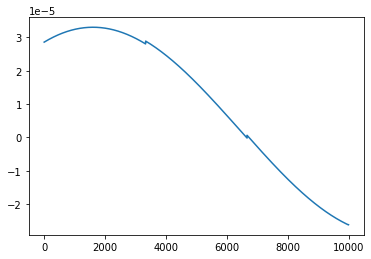

In [53]:
plt.plot(dddd[2])

In [220]:
fp_gpu-fp_real

array([-5.65375665e-05, -5.30453516e-05, -2.19071341e-05, -8.06043201e-06,
        3.47315427e-05,  3.07125366e-05,  8.66517929e-05,  2.81843600e-05,
       -5.43870591e-06, -7.04129506e-05])

In [221]:
fc_gpu-fc_real

array([-3.07599926e-05,  9.71602401e-06,  2.91876699e-05,  8.23354270e-05,
        4.93105117e-05,  5.77011522e-06, -3.33246178e-05, -5.21903564e-05,
       -2.03484881e-05, -5.99885284e-05])

In [222]:
dt_gpu - dt_real

array([ 5.31519273e-15, -8.26338550e-08, -1.48061706e-07,  6.03336825e-15,
       -5.53355255e-08, -9.16744686e-08,  6.08540995e-15, -2.79243491e-08,
       -4.00779232e-08,  5.50254287e-15])

In [44]:

class GWAntenna():
    def __init__(self, detector_name, device='cuda'):
        #self.det_bilby = sealgw.simulation.sealinterferometers.SealInterferometerList([detector_name])[0]
        self.det_bilby = bilby.gw.detector.InterferometerList([detector_name])[0]
        self.location = torch.from_numpy(self.det_bilby.vertex).type(torch.float64)
        self.detector_tensor = torch.from_numpy(self.det_bilby.geometry.detector_tensor).type(torch.float64)
        
        
    def response(self, ra, dec, psi, gpstime):
        bs = ra.shape[0]
        #D = self.detector_tensor.unsqueeze(0).repeat(bs, 1, 1)
        D = self.detector_tensor
        
        X = torch.zeros(bs, 3).type(torch.float64)
        Y = torch.zeros(bs, 3).type(torch.float64)

        # Greenwich hour angle of source (radians).
        # gha = gps2gmst(gpstime) - ra
        # The greenwich_mean_sidereal_time / gps2gmst can not be parallized on GPU
        # because it in the end needs a builtin fundamental function time.gmtime().
        # Therefore we have to make sure that gpstime is (almost) the same in the batch
        gha = torch.zeros_like(gpstime) + bilby.gw.utils.greenwich_mean_sidereal_time(gpstime[0]) - ra

        # pre-compute trig functions
        cosgha = torch.cos(gha)
        singha = torch.sin(gha)
        cosdec = torch.cos(dec)
        sindec = torch.sin(dec)
        cospsi = torch.cos(psi)
        sinpsi = torch.sin(psi)
    
        X[:,0] = -cospsi * singha - sinpsi * cosgha * sindec
        X[:,1] = -cospsi * cosgha + sinpsi * singha * sindec
        X[:,2] =  sinpsi * cosdec

        Y[:,0] =  sinpsi * singha - cospsi * cosgha * sindec
        Y[:,1] =  sinpsi * cosgha + cospsi * singha * sindec
        Y[:,2] =  cospsi * cosdec



        #fp = torch.einsum('ij,ijk,ik->i', X, D, X) - torch.einsum('ij,ijk,ik->i', Y, D, Y)
        #fc = torch.einsum('ij,ijk,ik->i', X, D, Y) + torch.einsum('ij,ijk,ik->i', Y, D, X)
        
        fp = torch.einsum('ij,jk,ik->i', X, D, X) - torch.einsum('ij,jk,ik->i', Y, D, Y)
        fc = torch.einsum('ij,jk,ik->i', X, D, Y) + torch.einsum('ij,jk,ik->i', Y, D, X)

        return fp, fc
    
    def time_delay_from_geocenter(self, ra, dec, gpstime):
        #gmst = gps2gmst(gpstime)
        bs = ra.shape[0]
        #loc = self.location.unsqueeze(0).repeat(bs, 1)

        gmst = torch.zeros_like(gpstime) + bilby.gw.utils.greenwich_mean_sidereal_time(gpstime[0]) #- ra
        long = gmst - ra
        lat = dec
        
        wavevector = torch.zeros(bs, 3).type(torch.float64)
        wavevector[:,0],wavevector[:,1],wavevector[:,2]  = \
            -torch.cos(long)*torch.cos(lat), -torch.cos(long)*torch.sin(lat), -torch.sin(long)
        
        print(wavevector.shape)
        print(self.location.shape)
        #dt = torch.dot(wavevector,self.location.unsqueeze(-1)) / 299792458
        #dt = torch.matmul(wavevector, self.location) / 299792458
        dt = torch.einsum('ij,j->i', wavevector, self.location) / 299792458
        
        #dt=1
        return dt
